<a href="https://colab.research.google.com/github/LeodeFaria/IDP/blob/main/idp_IA2_%C3%81rvore_de_Decis%C3%A3o_Exercicio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Árvore de Decisão - Exercicio

## Importando as bibliotecas


In [ ]:
# import ipynb_autograde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')
!pip install category_encoders

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.metrics import classification_report

from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

## Importando dataset


In [3]:
data = 'https://raw.githubusercontent.com/4tune-ai/IDP/main/data/car_evaluation.csv'

df = pd.read_csv(data, header=None)

In [4]:
# Renomeando Colunas
col_names = ['comprado', 'condicao', 'portas', 'passageiros', 'bagageiro', 'seguranca', 'classe']

df.columns = col_names

In [5]:
df.head()

,comprado,condicao,portas,passageiros,bagageiro,seguranca,classe
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


# Preprocessing

In [15]:
etiquetas = LabelEncoder()

df_final = df.copy()


df.loc[df.comprado=='low','comprado']=0
df.loc[df.comprado=='med','comprado']=0
df.loc[df.comprado=='high','comprado']=1
df.loc[df.comprado=='vhigh','comprado']=1

df_final['comprado']    = etiquetas.fit_transform(df_final['comprado'])
df_final['condicao']    = etiquetas.fit_transform(df_final['condicao'])
df_final['portas']      = etiquetas.fit_transform(df_final['portas'])
df_final['passageiros'] = etiquetas.fit_transform(df_final['passageiros'])
df_final['bagageiro']   = etiquetas.fit_transform(df_final['bagageiro'])
df_final['seguranca']   = etiquetas.fit_transform(df_final['seguranca'])
df_final['classe']      = etiquetas.fit_transform(df_final['classe'])
df_final.head()

,comprado,condicao,portas,passageiros,bagageiro,seguranca,classe
0,1,3,0,0,2,1,2
1,1,3,0,0,2,2,2
2,1,3,0,0,2,0,2
3,1,3,0,0,1,1,2
4,1,3,0,0,1,2,2


# Data Visualizing

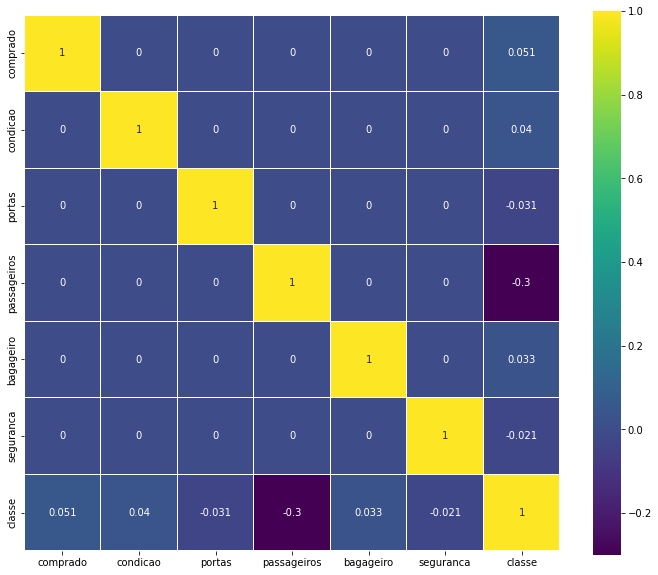

In [7]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,10))
sns.heatmap(df_final.corr(),cmap = colormap,annot=True,linewidths=0.1,square=True,linecolor='white',vmax=1.0)
plt.show()

# Decision Tree Classifier

In [16]:
X = df_final.drop('comprado',axis=1)
y = df_final['comprado']

X_treino, X_teste, y_treino, y_teste = train_test_split(X,y,train_size=0.7,random_state=42)

In [17]:
treino, teste = train_test_split(df_final, test_size=0.2, random_state=42, shuffle=True)

# o cv não funciona se não tiver um indice ok
treino.reset_index(drop = True,inplace = True)
teste.reset_index(drop = True, inplace = True)

In [18]:
treino.head()

,comprado,condicao,portas,passageiros,bagageiro,seguranca,classe
0,1,3,3,2,0,0,2
1,0,3,1,1,2,2,2
2,0,1,3,0,0,0,2
3,1,2,2,0,1,2,2
4,1,2,1,0,1,1,2


In [19]:
cv = KFold(n_splits=10)   

acuracia = list()
max_atributos = len(list(df_final))
profundidade = range(1, max_atributos + 1)

for nivel in profundidade:
    nivel_acuracia = []
    arvore = tree.DecisionTreeClassifier(max_depth = nivel)
    for nivel_treino, nivel_valido in cv.split(treino):
        f_treino = treino.loc[nivel_treino] 
        f_valido = treino.loc[nivel_valido] 

        modelo = arvore.fit(X = f_treino.drop(['comprado'], axis=1),
                            y = f_treino["comprado"]) 
        acc_valida = modelo.score(X = f_valido.drop(['comprado'], axis=1),
                                  y = f_valido["comprado"])
        nivel_acuracia.append(acc_valida)

    avg = sum(nivel_acuracia)/len(nivel_acuracia)
    acuracia.append(avg)
    
# Resultados 
df_arvore = pd.DataFrame({"Nível Máximo": profundidade, "Acuracia Média": acuracia})
df_arvore = df_arvore[["Nível Máximo", "Acuracia Média"]]
print(df_arvore.to_string(index=False))

 Nível Máximo  Acuracia Média
            1        0.525373
            2        0.572432
            3        0.572427
            4        0.596992
            5        0.620811
            6        0.593395
            7        0.591205


In [20]:
# Arrays Numpy p/ treino, teste and alvo (comprado) p/ modelo

niveis = 5

# Criando Arvore de Decisao com 5 níveis - melhor resultado bloco anterior
arvore_decisao = tree.DecisionTreeClassifier(max_depth = niveis)
arvore_decisao.fit(X_treino, y_treino)

# Predicting results for test dataset
y_predicao = arvore_decisao.predict(X_teste)
submetido = pd.DataFrame({
    "Comprado":y_teste,
    "Previsão":y_predicao
    })
submetido.head()

,Comprado,Previsão
599,1,0
1201,0,1
628,1,0
1498,0,0
1263,0,1


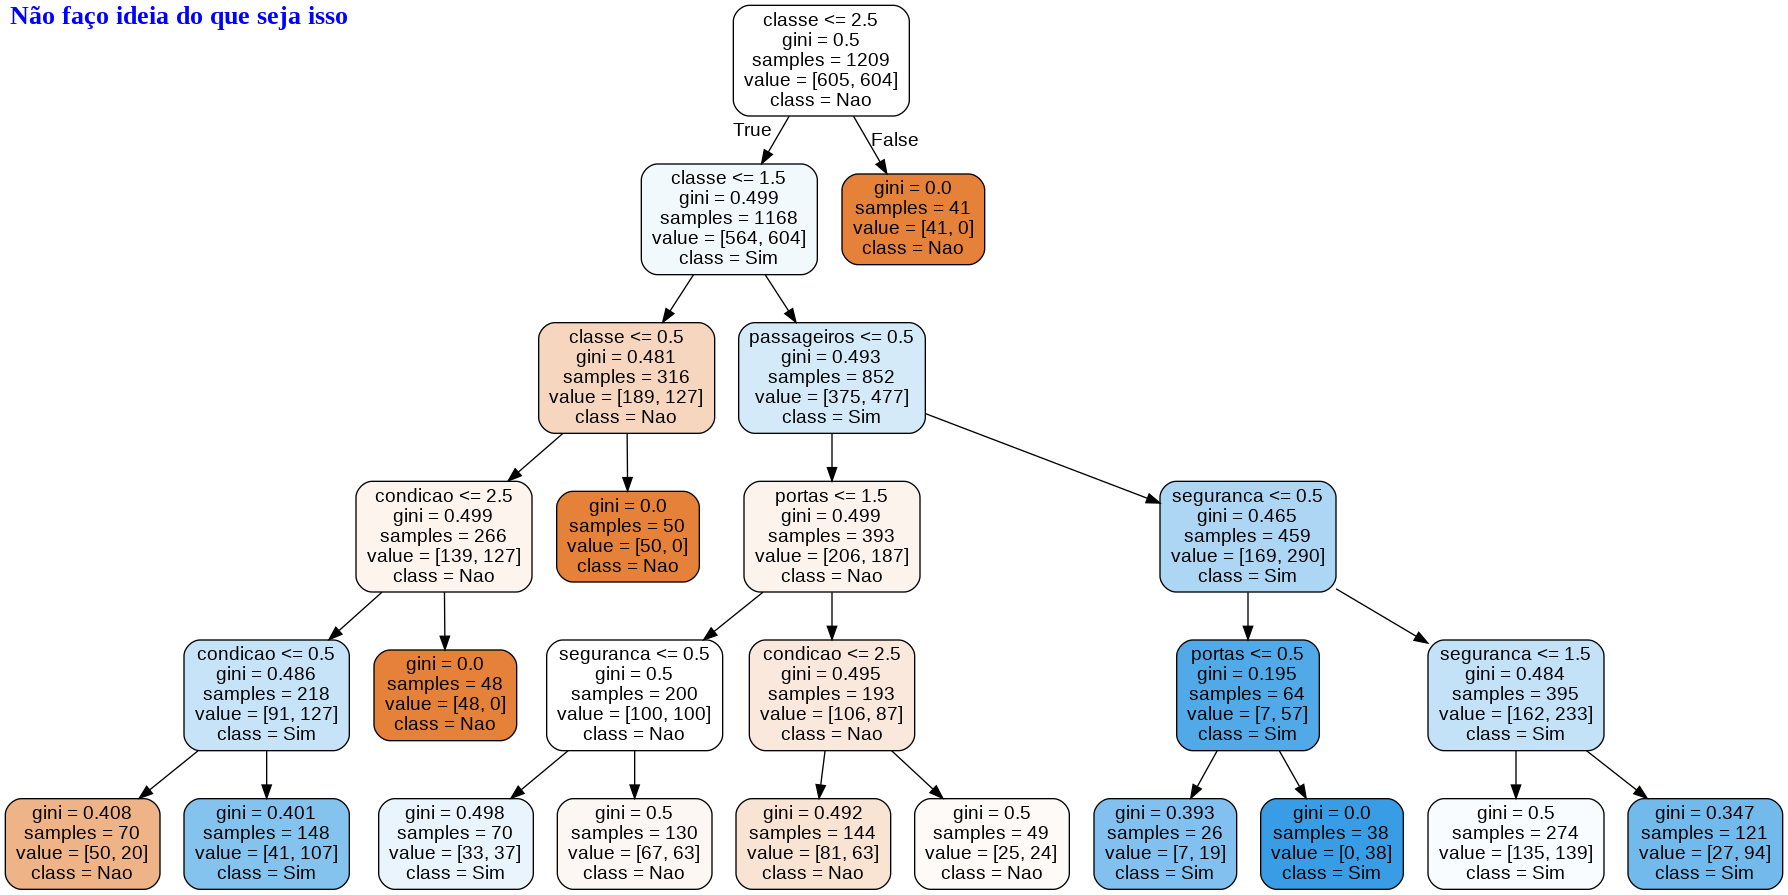

In [22]:
# Criação dos arquivos
submetido.to_csv('submission.csv', index=False)

# Export our trained model as a .dot file
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(arvore_decisao,
                              out_file=f,
                              max_depth = niveis,
                              impurity = True,
                              feature_names = list(treino.drop(['comprado'], axis=1)),
                              class_names = ['Nao', 'Sim'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])
#nao funcionou, fiz a conversao na mao.

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', 26)
draw.text((10, 0), # Drawing offset (position)
          'Não faço ideia do que seja isso', # Text to draw
          (0,0,255), # RGB desired color
          font=font) # ImageFont object with desired font
img.save('sample-out.png')
PImage("sample-out.png")

In [23]:
print(classification_report(y_teste,y_predicao))

              precision    recall  f1-score   support

           0       0.59      0.59      0.59       259
           1       0.59      0.59      0.59       260

    accuracy                           0.59       519
   macro avg       0.59      0.59      0.59       519
weighted avg       0.59      0.59      0.59       519

